TimeSformer

Using hugging face tutorial, does not work

In [48]:
from transformers import AutoImageProcessor, TimesformerModel

In [49]:
label2id = {"normal": 0, "talking": 1, "yawning": 2}
id2label = {i: label for label, i in label2id.items()}

In [65]:
model_ckpt = "facebook/timesformer-base-finetuned-k400"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = TimesformerModel.from_pretrained(
    model_ckpt,
    ignore_mismatched_sizes=True
    )

Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.3.intermediate.dense.weight', 'decoder.decoder_layers.3.attention.attention.value.weight', 'decoder.decoder_layers.3.layernorm_after.weight', 'decoder.decoder_layers.3.attention.attention.query.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.3.attention.attention.q_bias', 'decoder.decoder_layers.3.output.dense.bias', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.3.attention.output.dense.bias', 'decoder.decoder_layers.3.output.dense.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.1.output.dense.weight', 'decoder.decoder_layers.1.attention.attention.query.weight', 'decoder.decoder_layers.1.attention.output.dense.bias', 'encoder_to_decoder.weight', 'decoder.decoder_layers.1.attention.at

In [66]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 1
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [67]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [68]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    #UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    #UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

In [69]:
dataset_root_path = "../data/transformer/"
import os

In [70]:
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "small_train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform
)

In [71]:
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "small_val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=val_transform
)

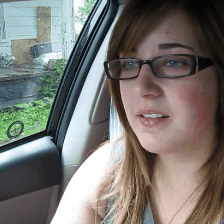

In [72]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [73]:
from transformers import TrainingArguments, Trainer

model_name = "test"
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4
batch_size = 1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [74]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [75]:
import torch

In [76]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [77]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [78]:
train_results = trainer.train()

  0%|          | 0/84 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_results = trainer.train()                                                              │
│   2                                                                                              │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\trainer.py:16 │
│ 64 in train                                                                                      │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\trainer.py:19 │
│ 40 in _inner_training_loop                                                                       │
│                                                                                                  │
│   1937 │   │   │   │   │   with model.no_sync():                                                 │
│   1938 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1939 │   │   │   │   else:                                                                     │
│ ❱ 1940 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1941 │   │   │   │                                                                             │
│   1942 │   │   │   │   if (                                                                      │
│   1943 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\trainer.py:27 │
│ 35 in training_step                                                                              │
│                                                                                                  │
│   2732 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2733 │   │                                                                                     │
│   2734 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2735 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2736 │   │                                                                                     │
│   2737 │   │   if self.args.n_gpu > 1:                     

In [4]:
MAX_SEQ_LENGTH = 1448
fps = 30
clip_duration = MAX_SEQ_LENGTH / fps

In [6]:
from pytorchvideo.transforms import ApplyTransformToKey
from torchvision.transforms import Compose, Lambda, Resize

c:\Users\xuton\Documents\Work\Year 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [6]:
IMG_SIZE = 128
resize_to = (IMG_SIZE, IMG_SIZE)

In [7]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    Lambda(lambda x: x / 255.0),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

In [8]:
import pytorchvideo.data
import os

In [9]:
dataset_root_path = "../data/transformer/"

In [10]:
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.RandomClipSampler(100),
    decode_audio=False,
    transform=train_transform
)

In [11]:
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.RandomClipSampler(100),
    decode_audio=False,
    transform=train_transform
)

In [12]:
from transformers import TrainingArguments, Trainer

In [13]:
model_name = "TimeSformer"
new_model_name = f"{model_name}-finetuned-ucf101-subset"
batch_size = 4
num_epochs = 25

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [14]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [15]:
import torch

def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [16]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    tokenizer=image_processor,
)

In [18]:
train_results = trainer.train()

c:\Users\xuton\Documents\Work\Year 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1525 [00:00<?, ?it/s]

c:\Users\xuton\Documents\Work\Year 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_results = trainer.train()                                                              │
│   2                                                                                              │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\trainer.py:16 │
│ 64 in train                                                                                      │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\transformers\trainer.py:19 │
│ 09 in _inner_training_loop                                                                       │
│                                                                                                  │
│   1906 │   │   │   │   rng_to_sync = True                                                        │
│   1907 │   │   │                                                                                 │
│   1908 │   │   │   step = -1                                                                     │
│ ❱ 1909 │   │   │   for step, inputs in enumerate(epoch_iterator):                                │
│   1910 │   │   │   │   total_batched_samples += 1                                                │
│   1911 │   │   │   │   if rng_to_sync:                                                           │
│   1912 │   │   │   │   │   self._load_rng_state(resume_from_checkpoint)                          │
│                                                                                                  │
│ c:\Users\xuton\Documents\Work\Year                                                               │
│ 5\Capstone\Code\se4450-project-group-23\model\.venv\lib\site-packages\torch\utils\data\dataloade │
│ r.py:634 in __next__                                                                             │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.It

import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)